 ### Bayesian Statistics, Course Project 
# Kaggle challenge on particle physics
# Logistic regression with Spike and Slab
### Vanilla and Horseshoe implementations


### Adrián Fernández Cid, Aitor Lucas Castellano, Marcos Moreno Blanco & Noel Rabella Gras
### 28-06-2021

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

## Outline
### 1. Data exploration and preprocessing   
### 2. Vanilla logistic regression with Spike and Slab
#### 2.1. Modelling
#### 2.2. Evaluation 

## 1. Data exploration and preprocessing

We have a tabular dataset with information on particle collisions recorded at the LHCb experiment at CERN, and the objective is to identify the presence of a specific process: **the decomposition of $B_0$ into $K^0$**. We therefore have a binary classification problem, in which the focus is placed on the pòsitive signal. This last point suggests we keep an eye on recall (also known as sensitivity) to maximise true postives.

Since the meaning of the predictors is not obvious, we include their description here:

**B_FDCHI2_OWNPV**: Flight distance of the B meson with respect to the primary vertex (point of proton-proton collision).

**B_IPCHI2_OWNPV**: Impact parameter. Shortest distance between the B meson trajectory and the primary vertex.

**B_PT**: B meson transverse momentum

**PIMINUS** & **KPLUS PSEUDORAPIDITY**: Angle of the piminus and Kplus particles with respect to the beam axis.

**KPLUS** & **PIMINUS P**: Kplus and piminus momentum.

**KST_892_0_COSTHETAH**: K* helicity angle. Angle formed bewteen one of the particle products of K* (piminus or Kplus) and the B meson in the reference frame of the K* (rest frame)
GAMMA_PT: photon transverse momentum.

**KST_892_0_IP_OWNPV**: Impact parameter of K*, which corresponds to the shortest distance between the K* trajectory and the primary vertex.

**B_OWNPV_CHI2**: Chi2 test of the primary vertex distribution.

**KPLUS** & **PIMINUS IP_OWNPV**: Shortest distance between the Kplus or the piminus trajectory and the primary vertex.

**B_DIRA_OWNPV**: Corresponds to the cosine of the angle formed by the momentum of the B meson and the vector formed between the initial (primary vertex) and final position (decay vertex) of the B meson.

The data, published code and other details of the challenge are available at:
https://www.kaggle.com/c/cernsignal/overview.



In [1]:
# load required packages for the whole notebook
require(mcsm)
require(bayesplot)
require(dplyr)
#install.packages("Epi",dependencies=TRUE,repos="https://cloud.r-project.org")
require(Epi)
#install.packages("corrplot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(corrplot)
#install.packages("R2jags",dependencies=TRUE,repos="https://cloud.r-project.org")
require(rstan)
#install.packages("pROC",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pROC)
#install.packages("unbalanced",dependencies=TRUE,repos="https://cloud.r-project.org")
require(unbalanced)
# install.packages("tree")
require(tree)
require(caret)
# install.packages("BoomSpikeSlab")
require(BoomSpikeSlab)

Loading required package: mcsm

Loading required package: MASS

Loading required package: coda

Loading required package: bayesplot

This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Epi

Loading required package: corrplot

corrplot 0.88 loaded

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend cal

Load labelled dataset (we will only use this):

In [2]:
train <- read.csv("data/train.csv")
names(train)
str(train)

[1] "Id"                  "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"     
 [4] "B_FDCHI2_OWNPV"      "B_DIRA_OWNPV"        "B_PT"               
 [7] "Kst_892_0_IP_OWNPV"  "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"     
[10] "Kplus_P"             "piminus_IP_OWNPV"    "piminus_P"          
[13] "gamma_PT"            "piminus_ETA"         "Kplus_ETA"          
[16] "BUTTER"              "signal"

'data.frame':	212662 obs. of  17 variables:
 $ Id                 : int  0 1 2 3 4 5 6 7 8 9 ...
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ BUTTER             : num  0.551 0.543 0.866 -0.443 -0.447 ...
 $ s

There are no NA (not available) values:

In [3]:
dim(train)
sum(is.na(train))
train=na.omit(train)
dim(train)
sum(is.na(train))

[1] 212662     17

[1] 0

[1] 212662     17

[1] 0

Remove **Id** (just an index) and **BUTTER** (an irrelevant column with butter consumption in Switzerland, purposely placed as a test). All other columns are numeric, so no need to factor any of them nor for a subsequent one-hot encoding.

In [4]:
data <- select(train, -Id
               , -BUTTER
              )
# rename "signal" column to fit the rest of the code
names(data)[names(data) == 'signal'] <- 'Response'
str(data)

'data.frame':	212662 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ Response           : num  1 1 1 0 0 0 1 0 0 0 ...


The variable **B_DIRA_OWNPV** seems to have little variability and therefore contain little information. We won't remove it just yet, but this is something to keep in mind:

In [5]:
summary(data$B_DIRA_OWNPV)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9995  1.0000  1.0000  1.0000  1.0000  1.0000 

Note the signal (presence of the process of interest $\equiv$ 1) is sparse:

In [13]:
n<-length(data$Response)
n
n1<-sum(data$Response)
n1
f<-n1/n
round(f,3)


[1] 212662

[1] 71030

[1] 0.334

In [14]:
positives=subset(data, data$Response==1)
negatives=subset(data, data$Response==0)

dim(data)
dim(positives)
dim(negatives)
#str(positives)

[1] 212662     15

[1] 71030    15

[1] 141632     15

For the sake of rigour, we take as large a subsample as we reasonably can (2000 samples takes a little more than 30 min to process with JAGS -which we do a total of 6 times-, so we settle for that number) and repeat the process another 2 times for consistency checks (all with a fixed seed, for reproducibility).

To render the process more agile, we define a function that does the subsampling of the specified half-size *nh* and *seed*:

In [15]:
subsample.balanced<-function(positives, negatives, nh, seed){
    sample.hsize<-nh
    set.seed(seed)   # for reproducibility
    # positive subsamples
    train.ind <- sample(seq_len(nrow(positives)),size = sample.hsize)  # Randomly (uniform dist) identifies the rows equal to sample size from  all the rows of data and stores the row number in train_ind
    pos.sample.train <- positives[train.ind,] #creates the training dataset with row numbers stored in train.ind
    pos.sample.test <- positives[-train.ind,]  # creates the test dataset excluding the row numbers mentioned in train.ind
    #negative subsamples
    train.ind <- sample(seq_len(nrow(negatives)),size = sample.hsize) 
    neg.sample.train <- negatives[train.ind,]
    neg.sample.test <- negatives[-train.ind,]  
    #final train and test subsets
    train.subsample<-bind_rows(pos.sample.train, neg.sample.train)
    test.subsample<-bind_rows(pos.sample.test, neg.sample.test)
    return(list("train"=train.subsample, "test"=test.subsample))
    }

And we take our 3 different subsamples:

In [16]:
nh<-1000#50
subsample.01 <- subsample.balanced(positives, negatives, nh=nh, seed=4)
train.01<-subsample.01$train
test.01<-subsample.01$test
#str(train.01)
#str(test.01)
subsample.02 <- subsample.balanced(positives, negatives, nh=nh, seed=44)
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03 <- subsample.balanced(positives, negatives, nh=nh, seed=444)
train.03<-subsample.03$train
test.03<-subsample.03$test

And format them for JAGS:

In [17]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

In [18]:
n<-length(y.01)
n
table(y.01)
#summary(x).01
n1<-sum(y.01)
f<-n1/n
round(f,3)

[1] 2000

y.01
   0    1 
1000 1000 

[1] 0.5

As we have seen in class, non-standardised data yields instability, so let us standardise x. Again, for agility, we define a function to do it:

In [19]:
standardise<-function(x){
    #compute means of every column (2 for columns, 1 for rows)) of X
    xm<-apply(x,2,mean)
    # center each column by substracting its mean
    xc<-sweep(x,2,xm,"-")
    # get standard dev of columns of xc
    xs<-apply(xc,2,sd)
    # standardise xc by dividing each column by its sd
    x0<-sweep(xc,2,xs,"/")
    return(x0)}

In [20]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [21]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1256224667

[1] 15.3

Another thing we should do is check the correlation between predictors (i.e. colinearity, which is invariant under centering and scaling). One should do it for all the available data, so we obtain a suitable dataframe:

In [22]:
colnames(data)[15]

[1] "Response"

In [23]:
x.corr<-model.matrix(Response~.,data)[,-1]
cn<-colnames(x.corr)
x.corr<-cbind(x.corr, data[, 15]) # add Response column
colnames(x.corr)<-c(cn, "Response")
str(x.corr)
#head(x.corr)

 num [1:212662, 1:15] 28.9 34.2 36.1 14.3 60.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:212662] "1" "2" "3" "4" ...
  ..$ : chr [1:15] "B_OWNPV_CHI2" "B_IPCHI2_OWNPV" "B_FDCHI2_OWNPV" "B_DIRA_OWNPV" ...


Note we have included the response in x.corr. this will give us a first hint of which predictors are most important for the classification. The plot of the correlation matrix is:

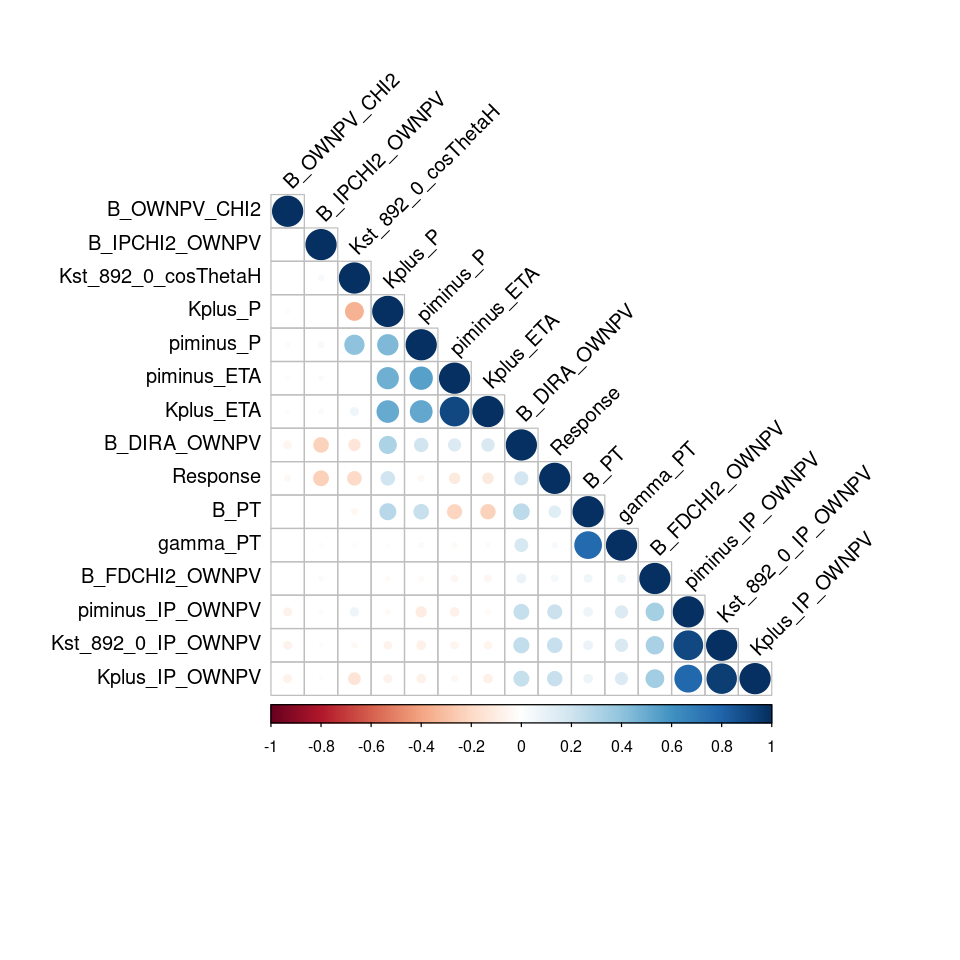

In [24]:
options(repr.plot.width=8,repr.plot.height=8)
corrplot(cor(x.corr), type="lower", order="hclust", tl.col="black", tl.srt=45)

Looks like we have remarkable positive correlation in the pairs **piminus_ETA/Kplus_ETA**, **B_PT/gamma_PT** and the triplet **piminus_IP_OWNPV/Kst_892_0_IP_OWNPV/Kplus_IP_OWNPV**, and negative correlation in the pairs **Kplus_P/Kst_892_0_cosThetaH**, **Kplus_IP_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/B_IPCHI2_OWNPV**, **B_PT/piminus_ETA** and **B_PT/Kplus_ETA**.

Regarding the response, is has strong negative correlation with **Kst_892_0_cosThetaH** and with **B_IPCHI2_OWNPV**.

The correlations between predictors that do not come from their contribution to determining the signal should in principle be picked out by the shrinkage prior, whose purpose is to cancel them by giving them vanishing coefficients.

## 2. Logistic Regression with Spike and Slab prior

### 2.1. Modelling

Define the model (very similar to what we did with the Challenger data):

In [29]:
sample.01 <- logit.spike(y.01~., as.data.frame(x0.01), niter = 5000)

=-=-=-=-= Iteration 0 Sun Jun 27 17:14:47 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sun Jun 27 17:14:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 1000 Sun Jun 27 17:14:48 2021 =-=-=-=-=
=-=-=-=-= Iteration 1500 Sun Jun 27 17:14:49 2021 =-=-=-=-=
=-=-=-=-= Iteration 2000 Sun Jun 27 17:14:50 2021 =-=-=-=-=
=-=-=-=-= Iteration 2500 Sun Jun 27 17:14:51 2021 =-=-=-=-=
=-=-=-=-= Iteration 3000 Sun Jun 27 17:14:52 2021 =-=-=-=-=
=-=-=-=-= Iteration 3500 Sun Jun 27 17:14:53 2021 =-=-=-=-=
=-=-=-=-= Iteration 4000 Sun Jun 27 17:14:53 2021 =-=-=-=-=
=-=-=-=-= Iteration 4500 Sun Jun 27 17:14:55 2021 =-=-=-=-=


In [26]:
sample.02 <- logit.spike(y.02~., as.data.frame(x0.02), niter = 5000)

=-=-=-=-= Iteration 0 Sun Jun 27 17:14:18 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sun Jun 27 17:14:19 2021 =-=-=-=-=
=-=-=-=-= Iteration 1000 Sun Jun 27 17:14:20 2021 =-=-=-=-=
=-=-=-=-= Iteration 1500 Sun Jun 27 17:14:21 2021 =-=-=-=-=
=-=-=-=-= Iteration 2000 Sun Jun 27 17:14:22 2021 =-=-=-=-=
=-=-=-=-= Iteration 2500 Sun Jun 27 17:14:22 2021 =-=-=-=-=
=-=-=-=-= Iteration 3000 Sun Jun 27 17:14:24 2021 =-=-=-=-=
=-=-=-=-= Iteration 3500 Sun Jun 27 17:14:24 2021 =-=-=-=-=
=-=-=-=-= Iteration 4000 Sun Jun 27 17:14:25 2021 =-=-=-=-=
=-=-=-=-= Iteration 4500 Sun Jun 27 17:14:26 2021 =-=-=-=-=


In [27]:
sample.03 <- logit.spike(y.03~., as.data.frame(x0.03), niter = 5000)

=-=-=-=-= Iteration 0 Sun Jun 27 17:14:30 2021 =-=-=-=-=
=-=-=-=-= Iteration 500 Sun Jun 27 17:14:31 2021 =-=-=-=-=
=-=-=-=-= Iteration 1000 Sun Jun 27 17:14:32 2021 =-=-=-=-=
=-=-=-=-= Iteration 1500 Sun Jun 27 17:14:33 2021 =-=-=-=-=
=-=-=-=-= Iteration 2000 Sun Jun 27 17:14:34 2021 =-=-=-=-=
=-=-=-=-= Iteration 2500 Sun Jun 27 17:14:35 2021 =-=-=-=-=
=-=-=-=-= Iteration 3000 Sun Jun 27 17:14:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 3500 Sun Jun 27 17:14:36 2021 =-=-=-=-=
=-=-=-=-= Iteration 4000 Sun Jun 27 17:14:37 2021 =-=-=-=-=
=-=-=-=-= Iteration 4500 Sun Jun 27 17:14:38 2021 =-=-=-=-=


Visualise output:

In [30]:
summary(sample.01)

null log likelihood:            -1386.294 
posterior mean log likelihood:  -1131.201 
posterior max log likelihood:   -1122.446 
mean deviance R-sq:             0.1840113 

predicted vs observed success rates, by decile:
               predicted   observed
(0.0413,0.172] 0.1192749 0.09045226
(0.172,0.262]  0.2186860 0.21500000
(0.262,0.337]  0.3020594 0.31500000
(0.337,0.408]  0.3704115 0.31500000
(0.408,0.483]  0.4459602 0.50000000
(0.483,0.56]   0.5207364 0.55000000
(0.56,0.645]   0.6045858 0.67500000
(0.645,0.734]  0.6875945 0.72000000
(0.734,0.833]  0.7801339 0.75000000
(0.833,0.997]  0.9015478 0.87000000

summary of coefficients:
                         mean      sd mean.inc sd.inc inc.prob
Kplus_P              1.02e+00 0.09010   1.0300 0.0865   0.9990
B_IPCHI2_OWNPV      -6.43e-01 0.05850  -0.6430 0.0564   0.9990
Kplus_ETA           -7.56e-01 0.10600  -0.7640 0.0704   0.9890
Kst_892_0_IP_OWNPV   5.47e-01 0.10800   0.5580 0.0773   0.9810
B_FDCHI2_OWNPV      -5.90e-02 0.18100  -0.

In [41]:
summary(sample.02)

null log likelihood:            -1386.294 
posterior mean log likelihood:  -1118.784 
posterior max log likelihood:   -1109.427 
mean deviance R-sq:             0.1929677 

predicted vs observed success rates, by decile:
               predicted   observed
(0.0289,0.165] 0.1073863 0.07537688
(0.165,0.256]  0.2137188 0.16500000
(0.256,0.337]  0.2951170 0.33500000
(0.337,0.416]  0.3793818 0.37000000
(0.416,0.486]  0.4490768 0.47000000
(0.486,0.567]  0.5219061 0.58500000
(0.567,0.639]  0.6039480 0.59500000
(0.639,0.74]   0.6927241 0.76500000
(0.74,0.843]   0.7913046 0.78000000
(0.843,0.992]  0.9051885 0.86000000

summary of coefficients:
                         mean       sd mean.inc  sd.inc inc.prob
Kplus_ETA           -6.56e-01 0.078300 -0.65600 0.07720   1.0000
Kplus_P              9.53e-01 0.107000  0.95300 0.10500   1.0000
B_IPCHI2_OWNPV      -6.55e-01 0.054900 -0.65500 0.05330   1.0000
Kst_892_0_IP_OWNPV   5.51e-01 0.241000  0.65000 0.06550   0.8480
Kst_892_0_cosThetaH -7.86e-02 0.

In [40]:
summary(sample.03)

null log likelihood:            -1386.294 
posterior mean log likelihood:  -1119.952 
posterior max log likelihood:   -1111.657 
mean deviance R-sq:             0.1921257 

predicted vs observed success rates, by decile:
               predicted   observed
(0.0246,0.163] 0.1125133 0.07035176
(0.163,0.255]  0.2077881 0.16500000
(0.255,0.338]  0.3001317 0.34000000
(0.338,0.413]  0.3745336 0.39500000
(0.413,0.486]  0.4481418 0.48500000
(0.486,0.567]  0.5243078 0.52000000
(0.567,0.643]  0.6038567 0.66500000
(0.643,0.734]  0.6900371 0.71500000
(0.734,0.843]  0.7877990 0.78500000
(0.843,0.997]  0.9054721 0.86000000

summary of coefficients:
                         mean       sd mean.inc  sd.inc inc.prob
Kplus_ETA           -7.21e-01 0.083900  -0.7210 0.08270   1.0000
Kplus_P              9.20e-01 0.080200   0.9210 0.07810   1.0000
B_IPCHI2_OWNPV      -6.15e-01 0.057400  -0.6150 0.05610   1.0000
Kplus_IP_OWNPV       4.92e-01 0.334000   0.7120 0.06950   0.6910
piminus_P           -1.06e-01 0.

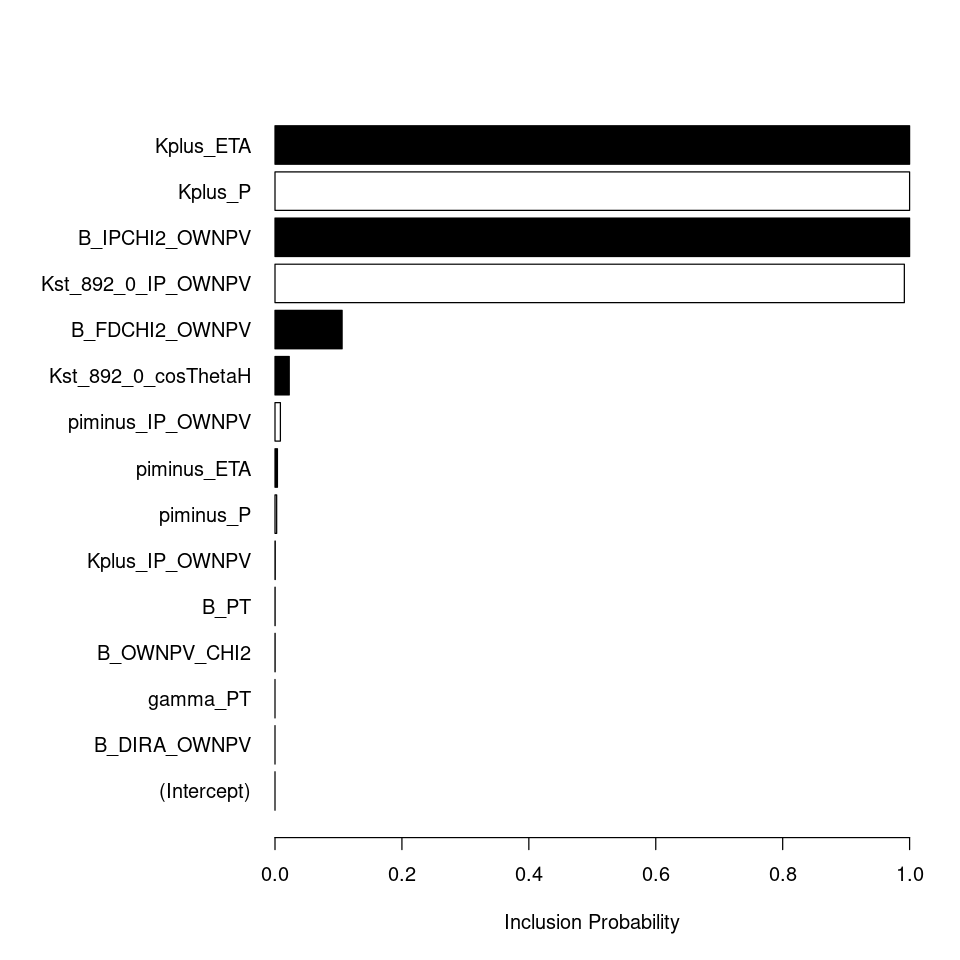

In [33]:
plot(sample.01)

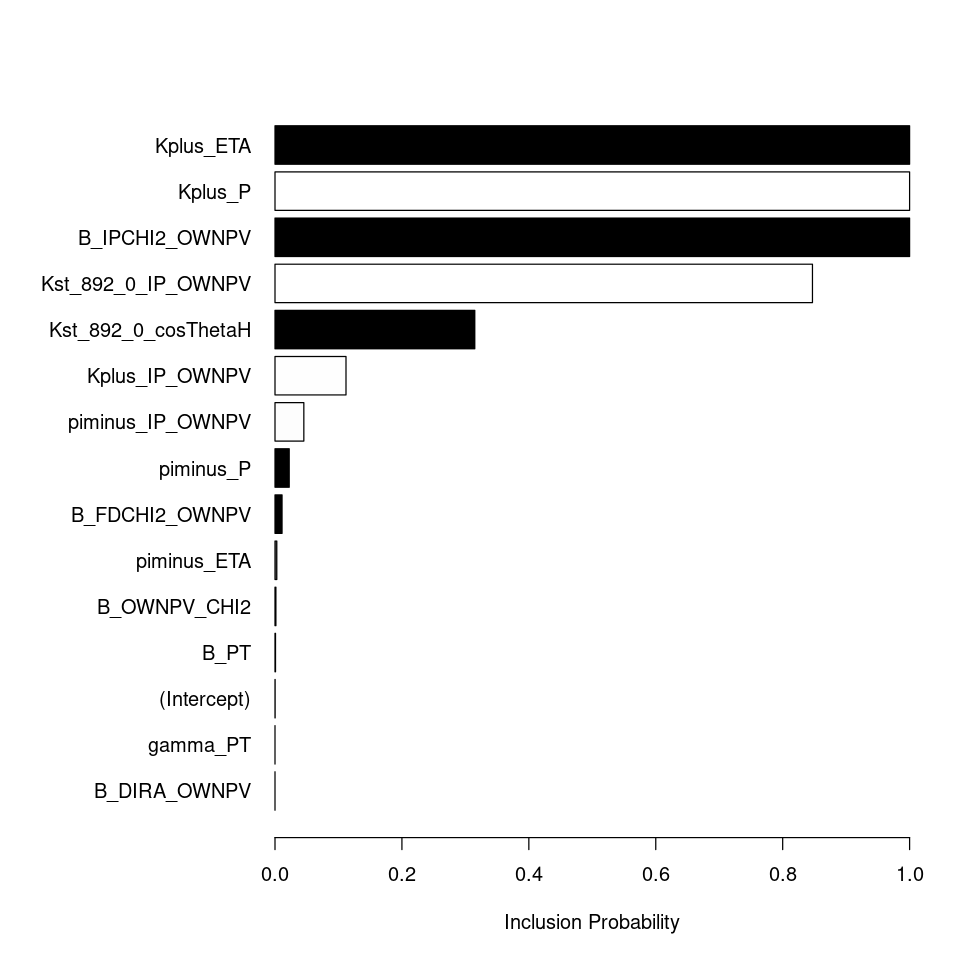

In [34]:
plot(sample.02)

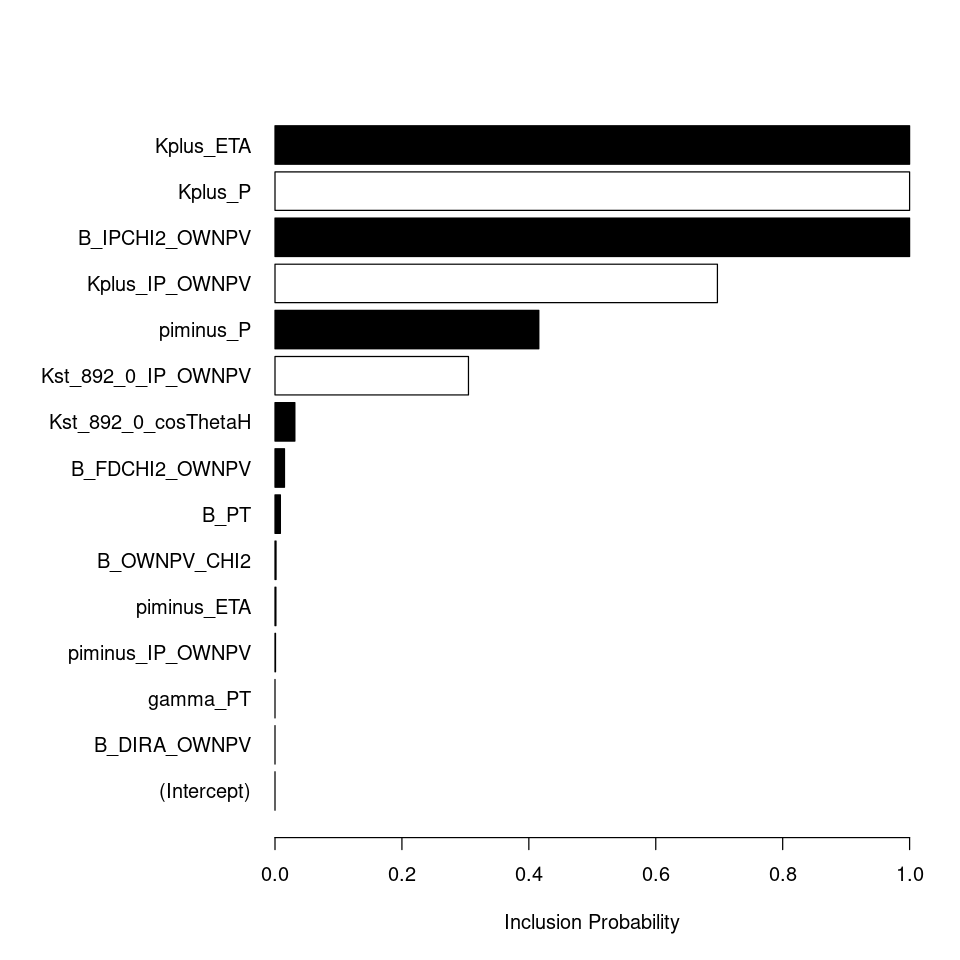

In [35]:
plot(sample.03)

In [31]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

Although there is some variability, the posterior means are consistent across subsamples, which contributes to validating their size (note that taking a greater subsample size would yield an unreasonable execution time for the notebook). 

It is worth noting $|\beta_{4}|$ (coefficient for **B_DIRA_OWNPV**) is $<0.05$ for all three original subsamples, meaning that it does not contribute much to the decision boundary. This confirms our intuition when exploring the data, where we already mentioned it is uninformative. The intercept $\beta_0$ is also suppressed.

### 2.2. Evaluation

To evaluate the model, we consider the train and test deviance, AIC and BIC. Since in this case we are applying Bayesian inference to a classification problem, we also compute the area under de ROC curve, which has the advantage over the latter that it is bounded and has absolute meaning (whereas deviation, AIC and BIC increase indefinitely with the size of the dataset used). Having established at the beginning of the notebook that we are mostly interested in true positives, we also look at recall (a.k.a. sensitivity, the fraction of total positives predicted as such): although we will show the other metrics for completeness, we will concentrate on AUC and recall, the latter computed for the optimal operating point of the ROC curve.

Note that for the test we use all samples not included in the corresponding 2000 train subsample, so **we test with about 210 000 samples** each time. We do this to put to use all available information, and we can afford to do so at test because we are just evaluating the logistic function (what took so long at train was the MCMC sampling).

In [247]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]    
    n.pars<-dim(x)[2]
    a <- as.numeric(sub('.*:', '', summary(sample.01$beta)[4,]))[1]
    b<-as.numeric(sub('.*:', '', summary(sample.01$beta)[4,]))[2:15]
    #probabilities
    eta.bar<-a + as.numeric(as.matrix(x) %*% b)
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){ 
        #compute threshold and recall/sensitivity for best operating point
        #in ROC curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        # optimal combination
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        check<-y+p.bar
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

Having our function, we call it for the result obtained for each original subsample:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7815
 train Deviance: 2255.075
 train AIC: 2283.075
 train BIC: 2361.487
 train recall/sensitivity 0.803

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7834
 test Deviance: 249957.2
 test AIC: 249985.2
 test BIC: 250128.8
 test recall/sensitivity 0.8556

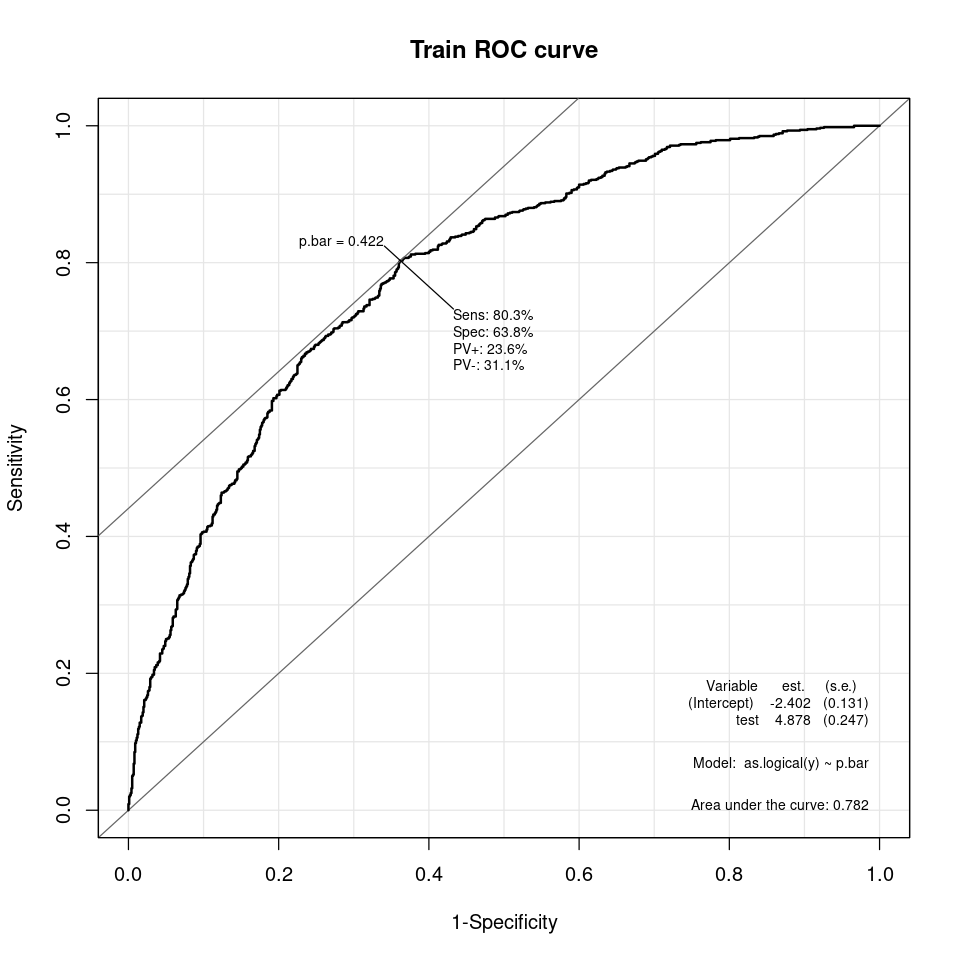

In [248]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7844
 train Deviance: 2240.181
 train AIC: 2268.181
 train BIC: 2346.594
 train recall/sensitivity 0.696

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7833
 test Deviance: 250002.5
 test AIC: 250030.5
 test BIC: 250174.1
 test recall/sensitivity 0.7504

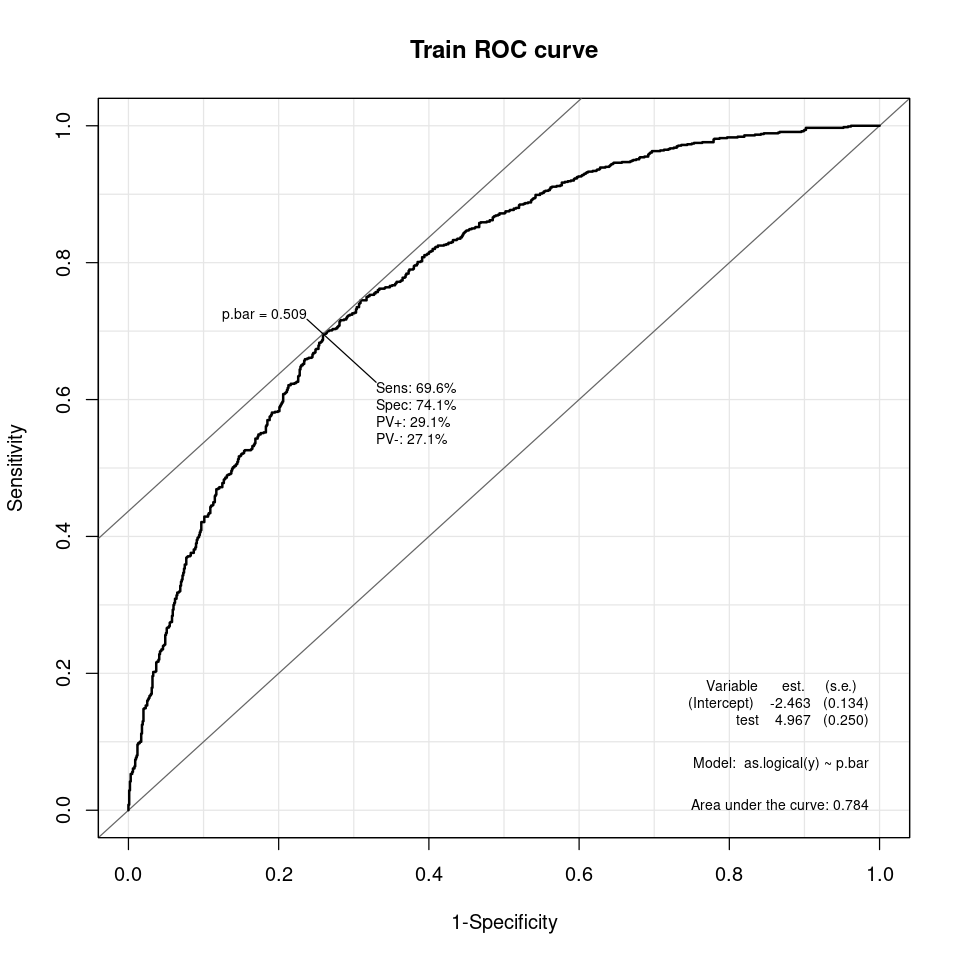

In [249]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7806
 train Deviance: 2255.895
 train AIC: 2283.895
 train BIC: 2362.307
 train recall/sensitivity 0.711

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7834
 test Deviance: 249958.6
 test AIC: 249986.6
 test BIC: 250130.2
 test recall/sensitivity 0.7864

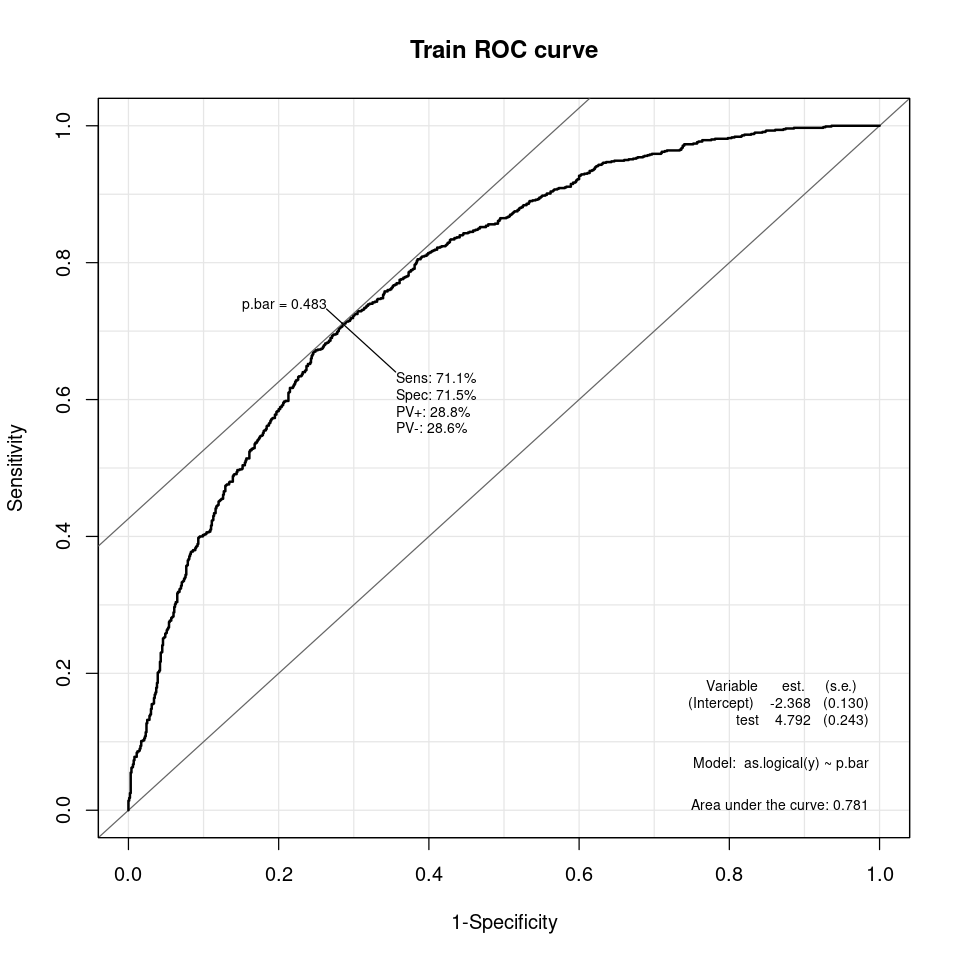

In [250]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

We get similar (and only moderately encouraging) test AUCs across subsamples (0.79), while test recall varies from 0.78 to 0.85. Not bad, if we consider that our train and test sizes (2 000 vs 210 000), although the AUC obtained by the winners of the competition was 0.94 and our own best result was as high as 0.90, both with a neural network. This difference may thus come from the dataset's not being linearly separable, added to the fact that the better results used many more samples for training/learning and many less for testing/"critisising" the model. We will see if we are able to improve our results by considering a more sophisticated undersampling strategy and an SVM instead of the logistic regression (although the SVM is still a linear classifier and would not help with nonlinearity).

The similarity across subsamples contributes to validating their size, with a caveat on the recall.